In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'NIPA/a-yo-image'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NIPA/a-yo-image


In [3]:
dataset = np.load('./initial-experiments/mongoose/data/data_run_offset_flip.npy')
# Split into train and validation sets using indexing to optimize memory.
dataset = dataset.reshape(-1, 128, 128, 4)
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
x_train = train_dataset / 255
x_test = val_dataset / 255

In [4]:
train_dataset.shape

(2295, 128, 128, 4)

In [5]:
# 오토인코더 모델 구조 정의
latent_dim = 64  # 잠재 공간의 크기

# 인코더
encoder_input = layers.Input(shape=(128, 128, 4))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoder_output = layers.Flatten()(x)
encoder_output = layers.Dense(latent_dim, activation="relu")(encoder_output)

encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,194,368 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,250,976 (16.22 MB)

 Trainable params: 4,250,976 (16.22 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 디코더
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(decoder_input)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(4, (3, 3), activation="sigmoid", padding="same")(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 65536)               │       4,259,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 4)         │           1,156 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,316,388 (16.47 MB)

 Trainable params: 4,316,388 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 오토인코더 연결
autoencoder_input = encoder_input
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = models.Model(autoencoder_input, decoded, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │       4,250,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 128, 128, 4)         │       4,316,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,567,364 (32.68 MB)

 Trainable params: 8,567,364 (32.68 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
# 얼리 스토핑 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',     # 검토할 메트릭 ('val_loss'도 사용 가능)
    patience=10,         # 성능 개선 없이 기다릴 에포크 수
    restore_best_weights=True  # 최상의 가중치를 복원할지 여부
)

# 학습
autoencoder.fit(x_train, x_train, epochs=2000, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.4384 - val_loss: 0.0800
Epoch 2/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0668 - val_loss: 0.0800
Epoch 3/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0692 - val_loss: 0.0800
Epoch 4/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 0.0691 - val_loss: 0.0800
Epoch 5/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0697 - val_loss: 0.0800
Epoch 6/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0663 - val_loss: 0.0800
Epoch 7/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0725 - val_loss: 0.0800
Epoch 8/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 0.0721 - val_loss: 0.0800
Epoch 9/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.0651 - val_loss: 0.0800
Epoch 10/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0717 - val_loss: 0.0800
Epoch 11/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0721 - val_loss: 0.0800


In [9]:
# 결과 확인
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step


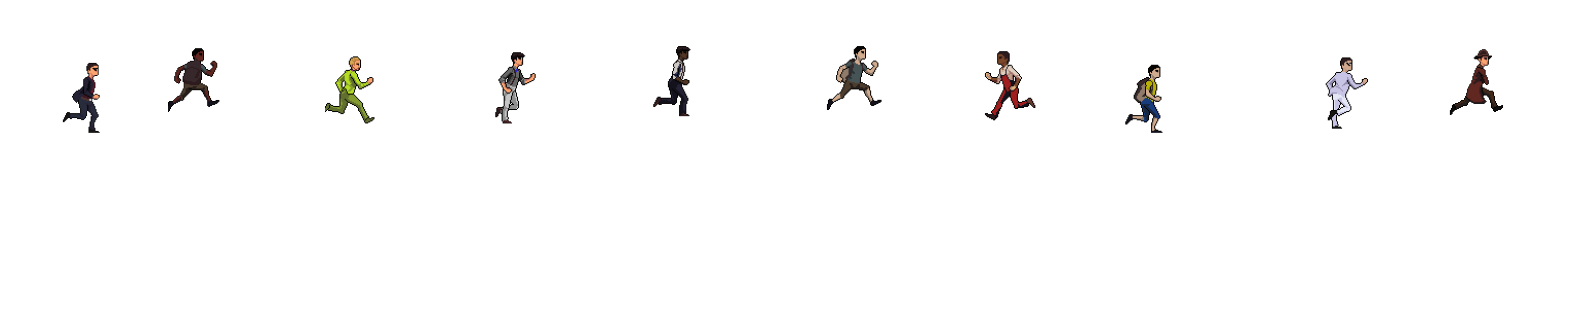

In [10]:
# 원본 이미지 및 재구성 이미지 시각화
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128, 4), cmap="gray")
    plt.axis("off")

    # 재구성 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128,4 ), cmap="gray")
    plt.axis("off")
plt.show()